In [53]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Dropout
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [54]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [55]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [56]:
cifar10_labels = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess data
SIZE = 32  
x_train = x_train / 255.0  
x_test = x_test / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

In [57]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [58]:
x_train_flat.shape

(50000, 3072)

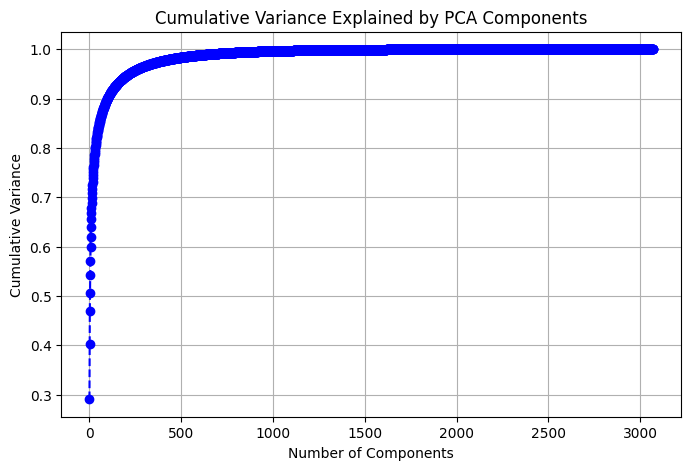

In [59]:
pca = PCA()
pca.fit(x_train_flat)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(cumsum, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Variance Explained by PCA Components")
plt.grid()
plt.show()

In [114]:
n_components = np.argmax(cumsum >= 0.95) + 1
print(f"Number of components selected to retain 95% variance: {n_components}")

Number of components selected to retain 95% variance: 217


In [111]:
pca = PCA(n_components=n_components)
train_PCA = pca.fit_transform(x_train_flat)
test_PCA = pca.transform(x_test_flat)

In [112]:
mlp_model = Sequential()

mlp_model.add(Input(shape=(n_components,)))
mlp_model.add(Dense(1024, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(10, activation='softmax'))

mlp_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)



#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, min_lr = 1e-5, patience = 4, verbose = 0)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('mlp_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
csv_logger = tf.keras.callbacks.CSVLogger('mlp.log')

mlp_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history = mlp_model.fit(train_PCA, y_train_one_hot, epochs = 50, batch_size = 32, validation_data=(test_PCA, y_test_one_hot), callbacks = [model_checkpoint, csv_logger])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 1024)              102400    
                                                                 
 batch_normalization_72 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_72 (Dropout)        (None, 1024)              0         
                                                                 
 dense_159 (Dense)           (None, 512)               524800    
                                                                 
 batch_normalization_73 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_73 (Dropout)        (None, 512)             

313/313 [==============================] - 2s 5ms/step
Final Test Loss: 1.1734
Final Test Accuracy: 0.5958


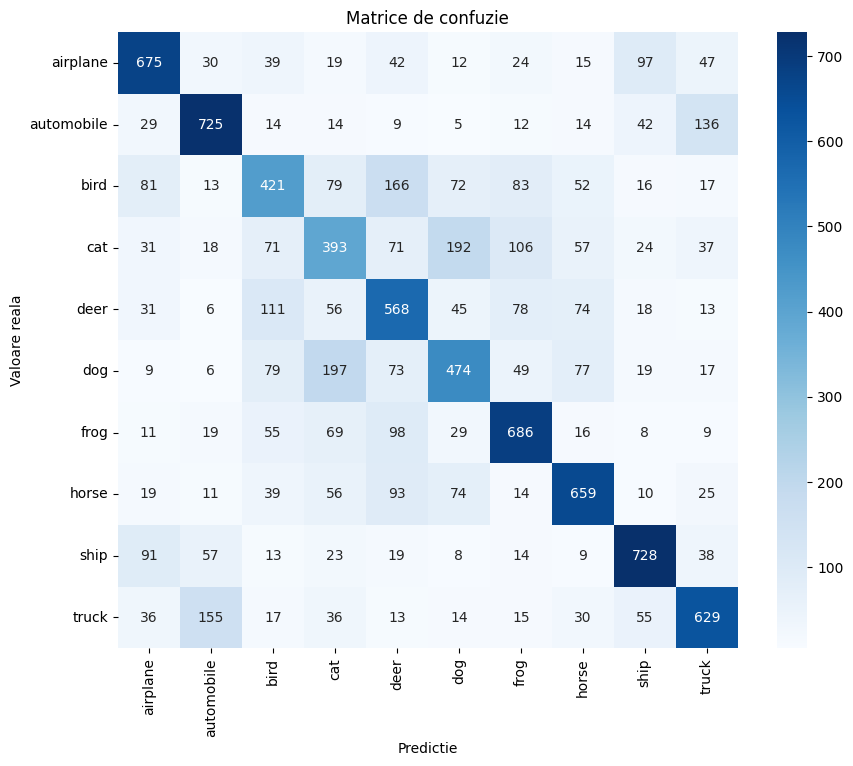

In [113]:
from keras.models import load_model

tester = load_model('mlp_best.h5')

y_pred = tester.predict(test_PCA)
y_pred_labels = np.argmax(y_pred, axis=1)


# Evaluate the classifier on the test set
test_loss, test_accuracy = tester.evaluate(test_PCA, y_test_one_hot, verbose=0)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels.values(), yticklabels=cifar10_labels.values())
plt.xlabel("Predictie")
plt.ylabel("Valoare reala")
plt.title("Matrice de confuzie")
plt.show()

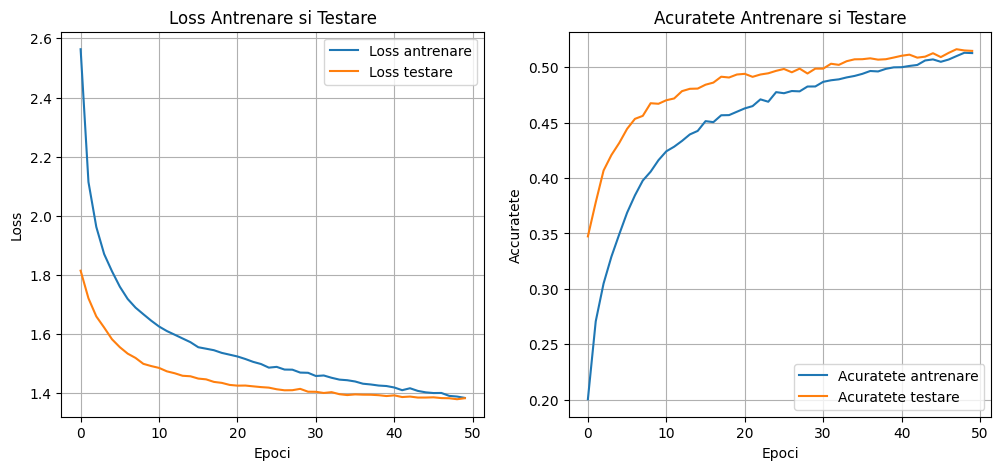

In [109]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss antrenare')
plt.plot(history.history['val_loss'], label='Loss testare')
plt.xlabel('Epoci')
plt.ylabel('Loss')
plt.title('Loss Antrenare si Testare')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acuratete antrenare')
plt.plot(history.history['val_accuracy'], label='Acuratete testare')
plt.xlabel('Epoci')
plt.ylabel('Accuratete')
plt.title('Acuratete Antrenare si Testare')
plt.legend()
plt.grid()

plt.show()

In [90]:
# continuam testarea pt. modelul cel mai bun

mlp_best_m1 = load_model('M1_0.0001_32.h5')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('mlp_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
csv_logger = tf.keras.callbacks.CSVLogger('mlp_best.log')

mlp_best_m1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
history = mlp_best_m1.fit(train_PCA, y_train_one_hot, epochs = 150, batch_size = 32, validation_data=(test_PCA, y_test_one_hot), callbacks = [model_checkpoint, csv_logger])

Epoch 1/150
1563/1563 [==============================] - 34s 20ms/step - loss: 0.9214 - accuracy: 0.6788 - val_loss: 1.2081 - val_accuracy: 0.5881
Epoch 2/150
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8500 - accuracy: 0.7058 - val_loss: 1.2121 - val_accuracy: 0.5924
Epoch 3/150
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8267 - accuracy: 0.7133 - val_loss: 1.2114 - val_accuracy: 0.5930
Epoch 4/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8034 - accuracy: 0.7213 - val_loss: 1.2197 - val_accuracy: 0.5968
Epoch 5/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7782 - accuracy: 0.7313 - val_loss: 1.2258 - val_accuracy: 0.5978
Epoch 6/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7793 - accuracy: 0.7285 - val_loss: 1.2230 - val_accuracy: 0.5969
Epoch 7/150
1563/1563 [==============================] - 29s 19ms/step - loss: 0.7480 - accuracy: 0.7412 - val_loss: 1

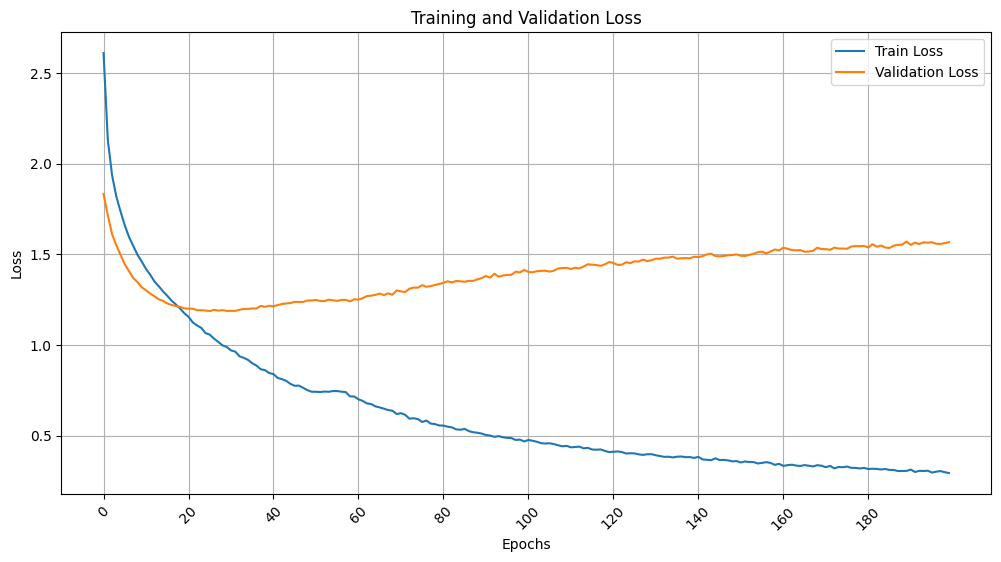

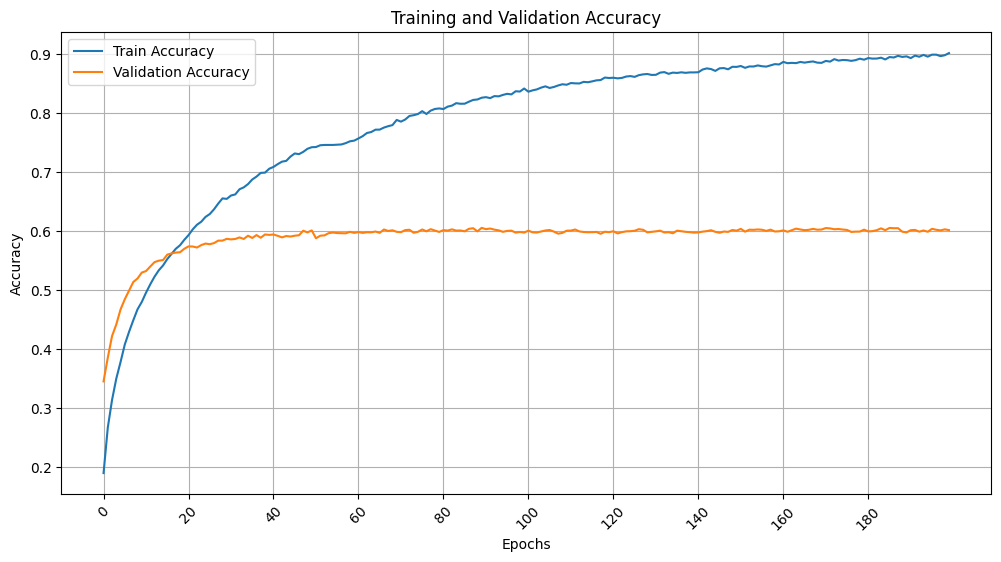

In [99]:
import pandas as pd

# Numele fișierului log
log_file = "M1_0.0001_32.log"

# Numele fișierului log
log_file = "M1_0.0001_32.log"

data = pd.read_csv(log_file)

plt.figure(figsize=(12, 6))
plt.plot(data["epoch"], data["loss"], label="Train Loss")
plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.xticks(ticks=data["epoch"][::len(data)//10], labels=data["epoch"][::len(data)//10], rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(data["epoch"], data["accuracy"], label="Train Accuracy")
plt.plot(data["epoch"], data["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.xticks(ticks=data["epoch"][::len(data)//10], labels=data["epoch"][::len(data)//10], rotation=45)
plt.show()